In [4]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm
from fuzzy_layer import FuzzyLayer

In [5]:
writer = SummaryWriter(f'runs/mnist/fсvae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 10
latent_dim = 2
hidden_dim = 128
significant_labels = 10 #количество размеченных классов, вся разметка от 10 и выше считается неразмеченным классом

In [6]:
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [7]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform=transform,
)
len(train_data)

60000

In [8]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform,
)
len(test_data)

10000

In [9]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [10]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.SiLU(),  
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.BatchNorm1d(hidden_dim // 8),
            nn.SiLU(),  
            nn.Linear(hidden_dim // 8, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z, dist

In [11]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.BatchNorm1d(hidden_dim // 8),
            nn.SiLU(), 
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.SiLU(), 
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.SiLU(), 
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.SiLU(), 
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [12]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(CVAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)        
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim)

        self.fuzzy = nn.Sequential(
             nn.Linear(latent_dim, 2),
             FuzzyLayer.fromcenters(initial_centers=[
                [ 0.8090169943,  0.5877852524], 
                [ 0.3090169938,  0.9510565165], 
                [-0.3090169938,  0.9510565165], 
                [-0.8090169943,  0.5877852524], 
                [-1.,            0.          ], 
                [-0.8090169943, -0.5877852524], 
                [-0.3090169938, -0.9510565165], 
                [ 0.3090169938, -0.9510565165], 
                [ 0.8090169943, -0.5877852524], 
                [ 1.,            0.          ]], trainable=True)

        )
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, _  = self.encoder(x)
        x_recon = self.decoder(mu)
        labels = self.fuzzy(mu)

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z, dist = self.encoder(x)
        labels = self.fuzzy(mu)

        return mu, logvar, z, dist, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [13]:
def compute_loss(x, recon_x, z, dist, target_labels, predicted_labels):
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    std_normal = torch.distributions.MultivariateNormal(
        torch.zeros_like(z, device=z.device),
        scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
    )
    loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()
            
    weight = torch.where(target_labels >= significant_labels, 0.0, 1.0)
    meaningful = sum(weight, 0)
    ratio = weight.shape[0]/ (meaningful+1)
    filteredLabels = torch.where(target_labels >= significant_labels, 0, target_labels)
    oh = nn.functional.one_hot(filteredLabels, significant_labels).reshape(predicted_labels.shape)
    #print(f"oh {oh.shape}")
    #print(f"predicted_labels-oh {(torch.sum(torch.square(predicted_labels-oh), dim=-1)).shape}")
    #print(f"weight {weight.shape}")
    #print(f"ratio {ratio.shape}")
    loss_fuzzy = ratio * torch.mean(torch.mul(weight, torch.sum(torch.square(predicted_labels-oh), dim=-1)))

    loss = loss_recon + loss_kl + loss_fuzzy

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [14]:
model = CVAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 224,598


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Linear(in_features=32, out_features=16, bias=True)
      (10): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): SiLU()
      (12): Linear(in_features=16, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=16, bias=True)
      (1): BatchNorm1d(16,

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [16]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        _, _, z, dist, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, z, dist, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Loss/Train/Fuzzy', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [17]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  
            
            _, _, z, dist, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, z, dist, target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/Fuzzy', loss_fuzzy.item(), global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [18]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 558.5047 (Recon: 556.2414, KL: 0.5755 Fuzzy: 1.6878) Grad: 36.9852
Step 100 (N samples: 12,800), Loss: 203.5506 (Recon: 199.9335, KL: 2.1805 Fuzzy: 1.4366) Grad: 32.0537
Step 200 (N samples: 25,600), Loss: 179.3716 (Recon: 174.5621, KL: 3.6823 Fuzzy: 1.1271) Grad: 27.1757
Step 300 (N samples: 38,400), Loss: 164.6362 (Recon: 159.2624, KL: 4.3594 Fuzzy: 1.0144) Grad: 31.4627
Step 400 (N samples: 51,200), Loss: 164.1094 (Recon: 158.4658, KL: 4.6666 Fuzzy: 0.9770) Grad: 30.6733


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 162.5704 (BCE: 157.0174, KLD: 4.6205 Fuzzy: 0.9325)
Epoch 2/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 500 (N samples: 64,000), Loss: 162.8799 (Recon: 157.1969, KL: 4.7899 Fuzzy: 0.8931) Grad: 36.5435
Step 600 (N samples: 76,800), Loss: 170.5427 (Recon: 164.7559, KL: 4.8812 Fuzzy: 0.9055) Grad: 41.4254
Step 700 (N samples: 89,600), Loss: 160.1838 (Recon: 154.3258, KL: 5.0167 Fuzzy: 0.8414) Grad: 43.2456
Step 800 (N samples: 102,400), Loss: 162.4163 (Recon: 156.5062, KL: 5.0552 Fuzzy: 0.8549) Grad: 46.9627
Step 900 (N samples: 115,200), Loss: 152.9527 (Recon: 146.9034, KL: 5.2633 Fuzzy: 0.7860) Grad: 41.8215


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 156.1468 (BCE: 150.0764, KLD: 5.2711 Fuzzy: 0.7992)
Epoch 3/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,000 (N samples: 128,000), Loss: 161.9349 (Recon: 155.8756, KL: 5.2536 Fuzzy: 0.8057) Grad: 66.7661
Step 1,100 (N samples: 140,800), Loss: 171.0459 (Recon: 164.9566, KL: 5.3196 Fuzzy: 0.7697) Grad: 75.3865
Step 1,200 (N samples: 153,600), Loss: 150.3279 (Recon: 144.2149, KL: 5.3654 Fuzzy: 0.7476) Grad: 46.9299
Step 1,300 (N samples: 166,400), Loss: 159.9062 (Recon: 153.7284, KL: 5.4358 Fuzzy: 0.7421) Grad: 57.4788
Step 1,400 (N samples: 179,200), Loss: 151.7022 (Recon: 145.4496, KL: 5.5319 Fuzzy: 0.7208) Grad: 59.5267


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 153.0187 (BCE: 146.8065, KLD: 5.5055 Fuzzy: 0.7067)
Epoch 4/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,500 (N samples: 192,000), Loss: 157.6136 (Recon: 151.3559, KL: 5.5336 Fuzzy: 0.7241) Grad: 49.5970
Step 1,600 (N samples: 204,800), Loss: 153.6675 (Recon: 147.4643, KL: 5.5141 Fuzzy: 0.6891) Grad: 73.4713
Step 1,700 (N samples: 217,600), Loss: 159.8281 (Recon: 153.5430, KL: 5.5940 Fuzzy: 0.6911) Grad: 92.5428
Step 1,800 (N samples: 230,400), Loss: 144.5628 (Recon: 138.2358, KL: 5.6803 Fuzzy: 0.6467) Grad: 53.4308


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 150.9231 (BCE: 144.7053, KLD: 5.5931 Fuzzy: 0.6247)
Epoch 5/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 1,900 (N samples: 243,200), Loss: 154.4823 (Recon: 148.1249, KL: 5.7071 Fuzzy: 0.6503) Grad: 82.7690
Step 2,000 (N samples: 256,000), Loss: 157.9136 (Recon: 151.6597, KL: 5.6466 Fuzzy: 0.6073) Grad: 65.7266
Step 2,100 (N samples: 268,800), Loss: 153.4218 (Recon: 147.0285, KL: 5.7921 Fuzzy: 0.6012) Grad: 77.9175
Step 2,200 (N samples: 281,600), Loss: 157.5970 (Recon: 151.2655, KL: 5.7220 Fuzzy: 0.6095) Grad: 73.2366
Step 2,300 (N samples: 294,400), Loss: 156.2504 (Recon: 149.8245, KL: 5.7967 Fuzzy: 0.6292) Grad: 56.6683


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 150.3832 (BCE: 144.1319, KLD: 5.6817 Fuzzy: 0.5696)
Epoch 6/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,400 (N samples: 307,200), Loss: 150.0916 (Recon: 143.8332, KL: 5.6819 Fuzzy: 0.5765) Grad: 81.4283
Step 2,500 (N samples: 320,000), Loss: 154.1278 (Recon: 147.7825, KL: 5.7471 Fuzzy: 0.5982) Grad: 55.6952
Step 2,600 (N samples: 332,800), Loss: 146.7280 (Recon: 140.4383, KL: 5.7893 Fuzzy: 0.5005) Grad: 58.6774
Step 2,700 (N samples: 345,600), Loss: 149.8331 (Recon: 143.3656, KL: 5.8664 Fuzzy: 0.6011) Grad: 96.2397
Step 2,800 (N samples: 358,400), Loss: 147.3660 (Recon: 140.8821, KL: 5.9100 Fuzzy: 0.5738) Grad: 76.8114


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 148.9382 (BCE: 142.5456, KLD: 5.8448 Fuzzy: 0.5478)
Epoch 7/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 2,900 (N samples: 371,200), Loss: 150.8913 (Recon: 144.5251, KL: 5.8397 Fuzzy: 0.5265) Grad: 70.7348
Step 3,000 (N samples: 384,000), Loss: 154.1274 (Recon: 147.7212, KL: 5.8587 Fuzzy: 0.5475) Grad: 106.9941
Step 3,100 (N samples: 396,800), Loss: 151.9806 (Recon: 145.5218, KL: 5.9224 Fuzzy: 0.5364) Grad: 62.9944
Step 3,200 (N samples: 409,600), Loss: 162.8123 (Recon: 156.4040, KL: 5.8446 Fuzzy: 0.5637) Grad: 82.4721


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.7697 (BCE: 141.3967, KLD: 5.8507 Fuzzy: 0.5223)
Epoch 8/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,300 (N samples: 422,400), Loss: 148.2220 (Recon: 141.8351, KL: 5.8830 Fuzzy: 0.5039) Grad: 93.0829
Step 3,400 (N samples: 435,200), Loss: 142.0951 (Recon: 135.4720, KL: 6.0939 Fuzzy: 0.5292) Grad: 54.5266
Step 3,500 (N samples: 448,000), Loss: 144.5234 (Recon: 138.0805, KL: 5.9557 Fuzzy: 0.4872) Grad: 51.4463
Step 3,600 (N samples: 460,800), Loss: 150.8708 (Recon: 144.4331, KL: 5.8837 Fuzzy: 0.5540) Grad: 63.4302
Step 3,700 (N samples: 473,600), Loss: 151.2547 (Recon: 144.7648, KL: 5.9625 Fuzzy: 0.5274) Grad: 62.1303


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 147.4950 (BCE: 140.9604, KLD: 6.0236 Fuzzy: 0.5110)
Epoch 9/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 3,800 (N samples: 486,400), Loss: 152.3437 (Recon: 145.8822, KL: 5.9588 Fuzzy: 0.5027) Grad: 69.4911
Step 3,900 (N samples: 499,200), Loss: 140.5839 (Recon: 134.0821, KL: 6.0258 Fuzzy: 0.4759) Grad: 52.5941
Step 4,000 (N samples: 512,000), Loss: 146.3995 (Recon: 139.8718, KL: 6.0385 Fuzzy: 0.4891) Grad: 65.7573
Step 4,100 (N samples: 524,800), Loss: 147.4017 (Recon: 140.9636, KL: 5.9457 Fuzzy: 0.4924) Grad: 72.6211
Step 4,200 (N samples: 537,600), Loss: 151.8381 (Recon: 145.0463, KL: 6.1527 Fuzzy: 0.6391) Grad: 84.1591


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.5316 (BCE: 140.0598, KLD: 5.9728 Fuzzy: 0.4990)
Epoch 10/10


  0%|          | 0/469 [00:00<?, ?it/s]

Step 4,300 (N samples: 550,400), Loss: 143.2914 (Recon: 136.8494, KL: 5.9750 Fuzzy: 0.4671) Grad: 93.6797
Step 4,400 (N samples: 563,200), Loss: 145.2977 (Recon: 138.7494, KL: 6.0631 Fuzzy: 0.4852) Grad: 76.1696
Step 4,500 (N samples: 576,000), Loss: 156.6756 (Recon: 150.1529, KL: 5.9411 Fuzzy: 0.5816) Grad: 86.9558
Step 4,600 (N samples: 588,800), Loss: 152.6164 (Recon: 145.9230, KL: 6.1373 Fuzzy: 0.5561) Grad: 76.3244


Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 146.5462 (BCE: 140.0320, KLD: 6.0177 Fuzzy: 0.4965)


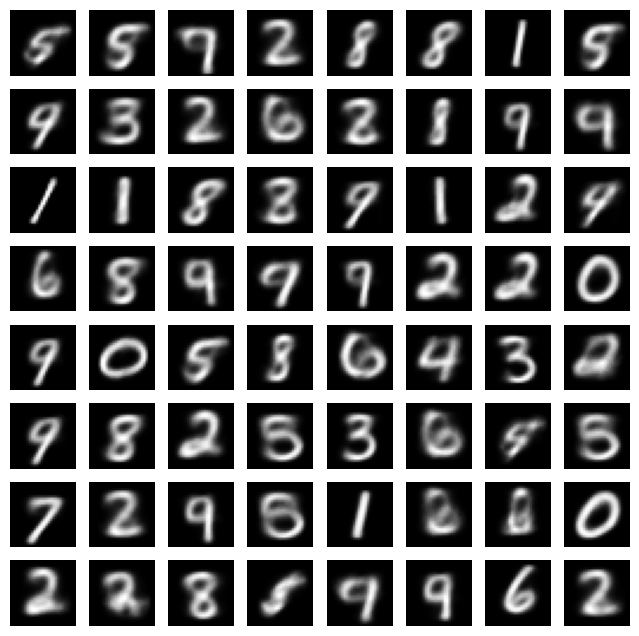

In [19]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [29]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(target.numpy())
        pred_y_all.append(np.argmax(labels.cpu().numpy()))

Encoding:   0%|          | 0/79 [00:00<?, ?it/s]

In [30]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
#pred_y_all= np.concatenate(pred_y_all, axis=0)

ValueError: 'c' argument has 79 elements, which is inconsistent with 'x' and 'y' with size 10000.

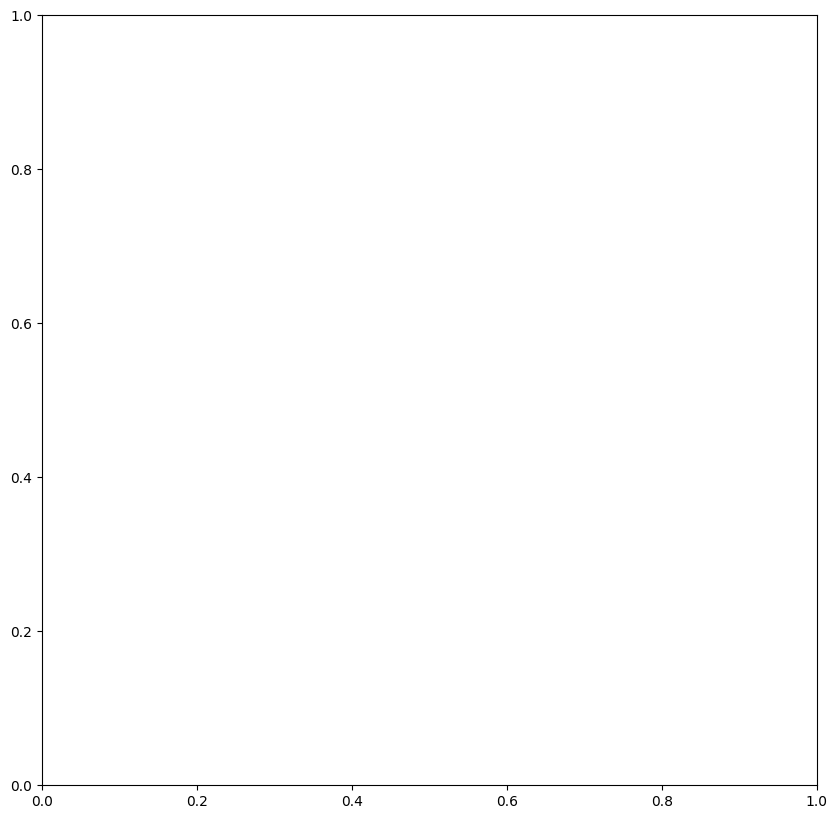

In [31]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

In [32]:
pred_y_all

[822,
 261,
 981,
 431,
 251,
 1151,
 770,
 1010,
 591,
 96,
 361,
 751,
 121,
 1271,
 281,
 1141,
 1061,
 451,
 1071,
 1211,
 1141,
 161,
 1121,
 381,
 271,
 681,
 1241,
 761,
 891,
 1031,
 1073,
 371,
 91,
 401,
 981,
 573,
 431,
 701,
 661,
 1211,
 361,
 61,
 841,
 727,
 1180,
 341,
 271,
 980,
 951,
 571,
 1061,
 121,
 271,
 793,
 11,
 1017,
 1121,
 682,
 561,
 923,
 421,
 600,
 310,
 1021,
 1217,
 1231,
 342,
 1027,
 1051,
 981,
 281,
 346,
 971,
 1201,
 1017,
 891,
 711,
 671,
 90]

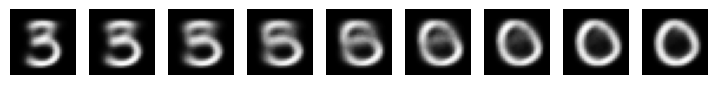

In [23]:
n = 9
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 1.2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('vae_mnist_interp.webp')